In [3]:
import os
import random
import carla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import importlib
import csv
import re

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import LLAMAconnect as llama

In [2]:
# Connecting to CARLA
town = 'Town05'  # Use Town01_Opt for a lighter version of Town01
client = carla.Client('localhost', 2000)
client.set_timeout(40)
world = client.get_world()
world = client.load_world(f'{town}_Opt') # Town01_Opt is a lighter version of Town01 with layers
world.unload_map_layer(carla.MapLayer.Foliage) # unload foliage for better perfomance 
world.unload_map_layer(carla.MapLayer.Particles) # unload particles for better performance
spectator = world.get_spectator()

In [3]:
# Blueprints and spawn points
vehicle_bp = world.get_blueprint_library().filter('vehicle.tesla.model3')[0]  # Get the first vehicle blueprint
spawn_points = world.get_map().get_spawn_points()

In [4]:
def destroy_vehicles():
    # Destroy all vehicles
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

## Setting up sensors

### IMU settings

In [5]:
def imu_callback(data):
    global imu_df
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_df.columns)

    imu_df = pd.concat([imu_df, new_data], ignore_index=True)

In [6]:
def set_attributes_IMU(imu_bp, sensor_tick=None, acc_noise=0.000, gyro_std=0.000, gyro_mean=0.000):
    if sensor_tick is not None:
        imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.    
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [7]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp)

### GNSS settings

In [8]:
def gnss_callback(data):
    global gnss_df
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_df.columns)

    gnss_df = pd.concat([gnss_df, new_data], ignore_index=True)

In [9]:
def set_attributes_GNSS(gnss_bp, sensor_tick=None, lat_bias=0, lat_sttdev=0, lon_bias=0, lon_stddev=0):
    if sensor_tick is not None:
        gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [10]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp)

## Traffic Manager

Traffic Manager is mostly used for vehicles from which there will be no data collected, meaning you can't controll their routine one the autopilot has been set.

In [11]:
def spawn_vehicles_tm(vehicles_bp, spawn_points, n_vehicles, dtlv=5, psd=80, hpm=True, hpr=50):
  # dtlv: distance to leading vehicle for all TM managed vehicles
  # psd: percentage speed difference for all TM managed vehicles. This means that all vehicles will drive at psd% of the speed limit.
  # hpm: hybrid physics mode. If True, simulate full physics only for vehicles near the ego vehicle (or camera)
  # hpr: radius in meters for hybrid physics mode. This means that all vehicles within hpr meters of the ego vehicle will be simulated with full physics.

  tm = client.get_trafficmanager()
  tm_port = tm.get_port()
  tm_vehs = []

  tm.set_synchronous_mode(True)
  tm.set_hybrid_physics_mode(hpm)

  if hpm:
    tm.set_hybrid_physics_radius(hpr)
  
  for i in range(n_vehicles):
    veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
    if veh:
      tm_vehs.append(veh)
      veh.set_autopilot(True, tm_port)
      tm.distance_to_leading_vehicle(veh, dtlv)
      tm.vehicle_percentage_speed_difference(veh, psd)
  
  print(f"Spawned {len(tm_vehs)} vehicles with Traffic Manager")

  return tm_vehs, tm_port

## Setting up Agents with Global Route Planner

These are build in agents that allow for route planning

In [12]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.

old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
from agents.navigation.custom_agent import CustomAgent
from agents.tools.misc import compute_distance
os.chdir(old_chdir)

In [13]:
def draw_all_spawnpoints(spawn_points):
    for i, sp in enumerate(spawn_points):
        world.debug.draw_string(
            sp.location,
            f'O{i}',  # Optional: add index label
            draw_shadow=False,
            color=carla.Color(r=0, g=255, b=0),  # Green
            life_time=500.0,
            persistent_lines=True
     )

In [14]:
def draw_route(routes, life_time=120):
    if not all(isinstance(route, list) for route in routes):
        print("Showing a single route")
        for w in routes:
            world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0), life_time=life_time,
            persistent_lines=True)
    else:
        print("Showing multiple routes")
        for route in routes:
            for w in route:
                world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=life_time,
                persistent_lines=True)

In [15]:
def draw_places_of_interest(sps_dict, life_time=120):

    for nome, w in sps_dict.items():
        world.debug.draw_string(w.location, f'{nome}', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=life_time,
        persistent_lines=True)


In [16]:
def generate_route(grp, desired_spawn_points, draw_debug_route=True):
    route = []
    for i in range(len(desired_spawn_points) - 1):
        route.append(grp.trace_route(desired_spawn_points[i].location, desired_spawn_points[i + 1].location))
    if draw_debug_route:
        draw_route(route, life_time=9999)
    return route

In [17]:
def get_closest_spawn_point(transform, spawn_points):
    closest_point = min(spawn_points, key=lambda sp: sp.location.distance(transform.location))
    return closest_point

In [18]:
def get_spawn_points_from_csv(csv_file):
    spawn_points = {}
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            loc = carla.Location(float(row['x']), float(row['y']), float(row['z']))
            rot = carla.Rotation(float(row['pitch']), float(row['yaw']), float(row['roll']))
            spawn_points[row['Name']] = carla.Transform(loc, rot)
    
    return spawn_points

In [19]:
def get_response_LLM(places_of_interest, student_routine=False):
    """
    Function to get a response from the LLM.
    :param places_of_interest: List of places of interest.
    :param radom_trip: If True, the LLM prompt will not be restricted to a student routine.
    :return: Response from the LLM.
    """

    importlib.reload(llama)

    if student_routine:
        response = llama.getResponse_trip(places_of_interest)
    else:
        response = llama.getResponse_trip_random(places_of_interest)

    while not llama.responseCheck(response, places_of_interest):
        if student_routine:
            response = llama.getResponse_trip(places_of_interest)
        else:
            response = llama.getResponse_trip_random(places_of_interest)

    response = json.loads(response)
    return response

In [20]:
def follow_route(vehicle_bp, sensors_bp, route_sps, agent_behavior='normal', delta_time=0.01, stop_time=0, freeze_traffic_lights = False, n_vehicles=30, sampling_res=2, fixed_spectator=True, draw_debug_route=True, render=True):
    """
    Follow the route using the vehicle.

    vehicle_bp: Blueprint of the vehicle to be spawned.
    sensors_bp: List of sensor blueprints to be attached to the vehicle.
    spawn_points: List of possible spawn points for vehicles to be spawned.
    route_sps: List of spawn points to follow the route.
    agent_behavior: Behavior of the agent (default is 'normal').
    delta_time: Time step for the simulation (default is 0.05).
    stop_time: How much time to stop at each waypoint (default is 0).
    n_vehicles: Number of vehicles to spawn (default is 30).
    sampling_res: Sampling resolution for the global route planner (default is 2).
    fixed_spectator: If True, the spectator will follow the vehicle (default is True).
    draw_debug_route: If True, the route will be drawn in the world (default is True).
    render: If True, rendering will be enabled (default is True).
    """
    # Set up spectator
    spectator = world.get_spectator()
    spectator.set_transform(route_sps[0])

    if freeze_traffic_lights:
        for tl in world.get_actors().filter('traffic.traffic_light'):
            tl.set_state(carla.TrafficLightState.Green)
            tl.freeze(True)

    amap = world.get_map()
    grp = GlobalRoutePlanner(amap, sampling_res)
    # Create a global route planner and setting up car
    route = generate_route(grp, route_sps, draw_debug_route=draw_debug_route)
    vehicle_bp.set_attribute('role_name', 'hero')  # Important for carlaviz and for TM
    vehicle = world.spawn_actor(vehicle_bp, route_sps[0])
    agent = BehaviorAgent(vehicle, behavior=agent_behavior)  # options: 'normal', 'aggressive', etc.
    agent.set_global_plan(route[0])  # Set the global plan for the agent

    # Set up sync mode
    settings = world.get_settings()
    settings.synchronous_mode = True  # Enable sync mode
    settings.fixed_delta_seconds = delta_time  # Set the fixed delta time
    settings.no_rendering_mode = not render
    world.apply_settings(settings)
    print(f"Delta time set to {delta_time} seconds. Synchronous mode enabled.")

    # Waiting initialization
    for _ in range(5):
        world.tick()

    # Attach sensors to the vehicle BEFORE synchronous mode 
    sensor_actors = [] # Hold references to sensor actors to prevent garbage collection
    print(f"Spawning {len(sensors_bp)} sensors...")
    for sensor_bp in sensors_bp:
        # Setting the sensors at the windshield of the vehicle
        sensor = world.spawn_actor(sensor_bp, carla.Transform(carla.Location(z=1.3, x=0.3)), attach_to=vehicle)
        sensor.set_simulate_physics(False)
        sensor_actors.append(sensor)
    print(f"Spawned {len(sensor_actors)} sensors.")

    # Initializing other cars using TM
    if n_vehicles > 0:
        spawn_vehicles_tm(world.get_blueprint_library().filter('vehicle.*'), amap.get_spawn_points(), n_vehicles=n_vehicles, dtlv=5, psd=-0, hpm=True, hpr=50)

    # Waiting a little bit more for initialization
    for _ in range(5):
        world.tick()

    # next_stop = route[0][1]  # The next stop is the first waypoint of the route
    # Listen to sensors AFTER synchronous mode
    for sensor in sensor_actors:
        if sensor.type_id == 'sensor.other.imu':
            print("IMU sensor attached.")
            sensor.listen(lambda data: imu_callback(data))
        elif sensor.type_id == 'sensor.other.gnss':
            print("GNSS sensor attached.")
            sensor.listen(lambda data: gnss_callback(data))

    route_count = 0
    try:
        while True:

            print(f"Remaining WP: {len(agent._local_planner._waypoints_queue)}")
            if agent.done():
                route_count += 1
                print(f"Path up to {route_sps[route_count]} completed.")
                waiting = True
                if route_count == len(route_sps) - 1:
                    print("Route completed.")
                    break
                
                agent.set_global_plan(route[route_count])  # Update the global plan for the agent
                print(f"New route set from {route_sps[route_count]} to {route_sps[route_count + 1]}.")


            vehicle.apply_control(agent.run_step())    

            # Update spectator position
            if fixed_spectator:
                # Spectator follows the vehicle
                spectator.set_transform(carla.Transform(vehicle.get_transform().location + carla.Location(z=40), carla.Rotation(pitch=-90)))
            
            world.tick()

    except KeyboardInterrupt:
        print("Simulation interrupted by user.")

    finally:
        for sensor in world.get_actors().filter('sensor.other.*'):
            sensor.destroy()
        
        destroy_vehicles()
        print("All actors destroyed.")

        # Disable sync mode
        settings.synchronous_mode = False
        world.apply_settings(settings)

## Routines in town Experiment

### Generating routines

In [21]:
sps = get_spawn_points_from_csv(f'interests_spawn_points_{town}.csv')
places = list(sps.keys())
print(f'Possible places: {places}')

Possible places: ['home', 'work', 'school', 'gym', 'bar', 'theater', 'cafe', 'university']


Using LLM to generate trips

In [22]:
n_of_routines = 3

generated_routines = 0
while (generated_routines < n_of_routines):
    try:
        response = get_response_LLM(places)
        print(response)
        df = pd.DataFrame(response).T
        df.index.name = 'time'
        os.makedirs('llm_routines', exist_ok=True)
        df.to_csv(f'llm_routines/llm_routine{generated_routines}.csv')
        generated_routines += 1

    except Exception as e:
        print(f"Error generating routine. Trying again. Error: {e}")
        continue

sps_routine = [] # This is a list of spawnpoint to generate the routine
places_routine = [] # This is a list of places to generate the routine
for locs in response.values():
    local = locs['location']
    places_routine.append(local)
    sps_routine.append(sps[local])

print(places_routine)

{'7': {'location': 'home', 'activity': 'wake up'}, '8': {'location': 'school', 'activity': 'work'}, '9': {'location': 'work', 'activity': 'office work'}, '10': {'location': 'home', 'activity': 'break'}, '11': {'location': 'gym', 'activity': 'workout'}, '12': {'location': 'home', 'activity': 'lunch'}, '13': {'location': 'university', 'activity': 'study'}, '14': {'location': 'gym', 'activity': 'workout'}, '15': {'location': 'cafe', 'activity': 'snack'}, '16': {'location': 'theater', 'activity': 'watch movie'}, '17': {'location': 'home', 'activity': 'collect kids'}, '18': {'location': 'school', 'activity': 'pick up kids'}, '19': {'location': 'bar', 'activity': 'relax'}, '20': {'location': 'home', 'activity': 'spend time with family'}, '21': {'location': 'gym', 'activity': 'evening workout'}, '22': {'location': 'home', 'activity': 'dinner'}, '23': {'location': 'home', 'activity': 'sleep'}}
{'7': {'location': 'home', 'activity': 'wake up'}, '8': {'location': 'gym', 'activity': 'morning work

In [23]:
n_of_routines = len(os.listdir(f"llm_routines"))

routines = []
for i in range(n_of_routines):
    routine_csv = f'llm_routines/llm_routine{i}.csv'
    df = pd.read_csv(routine_csv)
    routines.append(df)

In [ ]:
whole_df = pd.DataFrame()
delta_time = 0.01 # FPS of the simulation is 1 / delta_time
behaviors = ['normal', 'aggressive']
for beh in behaviors:
    for i in range(n_of_routines):
        try: 
            routine = routines[i]
            places_routine = routine.location.values.tolist()
            sps_routine = list(map(lambda x: sps[x], places_routine))
            # timestamp: simulation time - s
            # acc: m/s^2
            # gyro: rad/s
            # compass: rad
            imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

            # timestamp: simulation time - s
            # latitude: rad
            # longitude: rad
            # orientation: rad
            gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

            agent_behavior = beh  # options: 'normal', 'aggressive', etc.
            id = f'veh{i}_carla_{agent_behavior}'

            print(f"Vehicle will go to the following places: {places_routine}")
            # Here traffic lights are frozen to green in order to reduce simulation time
            follow_route(vehicle_bp, [IMU_bp, GNSS_bp], sps_routine, agent_behavior=agent_behavior, freeze_traffic_lights=False, n_vehicles=10, delta_time=delta_time, sampling_res=1, fixed_spectator=True, draw_debug_route=True, render=True)

            whole_df = pd.merge(imu_df, gnss_df, on='timestamp', how='outer')[3:]
            whole_df['timestamp'] = whole_df['timestamp'] - whole_df['timestamp'].iloc[0] # Normalize time to start from 0

            os.makedirs(f'data_experiment2_carla_{town}', exist_ok=True)
            whole_df.to_csv(f'data_experiment2_carla_{town}/{id}.csv', index=False)

            print(f"\n------------------ VEHICLE {id} FINISHED ---------------------------\n")
        
        except KeyboardInterrupt as e:
            print(f"Simulation interrupted by user. Error: {e}")
            break

Vehicle will go to the following places: ['home', 'school', 'work', 'home', 'gym', 'home', 'university', 'gym', 'cafe', 'theater', 'home', 'school', 'bar', 'home', 'gym', 'home', 'home']
Showing multiple routes
Delta time set to 0.1 seconds. Synchronous mode enabled.
Spawning 2 sensors...
Spawned 2 sensors.
Spawned 10 vehicles with Traffic Manager
IMU sensor attached.
GNSS sensor attached.
Remaining WP: 183
Remaining WP: 182
Remaining WP: 182
Remaining WP: 182
Remaining WP: 182
Remaining WP: 182
Remaining WP: 182
Remaining WP: 182
Remaining WP: 176
Remaining WP: 175
Remaining WP: 174
Remaining WP: 174
Remaining WP: 173
Remaining WP: 172
Remaining WP: 171
Remaining WP: 171
Remaining WP: 170
Remaining WP: 169
Remaining WP: 168
Remaining WP: 168
Remaining WP: 167
Remaining WP: 166
Remaining WP: 165
Remaining WP: 164
Remaining WP: 163
Remaining WP: 163
Remaining WP: 162
Remaining WP: 162
Remaining WP: 161
Remaining WP: 160
Remaining WP: 159
Remaining WP: 158
Remaining WP: 158
Remaining WP:

In [4]:
def plot_df(df, idx, save_path = None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acceleration
    axes[0].plot(df['timestamp'], df['acc_x'], label='Acc X')
    axes[0].plot(df['timestamp'], df['acc_y'], label='Acc Y')
    # axes[0].plot(df['timestamp'], df['acc_z'], label='Acc Z')
    axes[0].set_title("Acceleration over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot gyroscope
    axes[1].plot(df['timestamp'], df['gyro_x'], label='Gyro X')
    axes[1].plot(df['timestamp'], df['gyro_y'], label='Gyro Y')
    axes[1].plot(df['timestamp'], df['gyro_z'], label='Gyro Z')
    axes[1].set_title("Gyroscope over Time")
    axes[1].set_ylabel("Angular Velocity (rad/s)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot position
    scatter = axes[2].scatter(df['longitude'], df['latitude'], c=df['timestamp'], cmap='viridis', s=10)
    axes[2].set_title("Position (Latitude vs Longitude) colored by Time")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")
    axes[2].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[2])
    cbar.set_label("Time (s)")

    # Set a single title for the entire figure
    fig.suptitle(f"CARLA Simulator data for route {idx}", fontsize=16)

    # plt.tight_layout(rect=[0, 0, 1, 0.99])
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

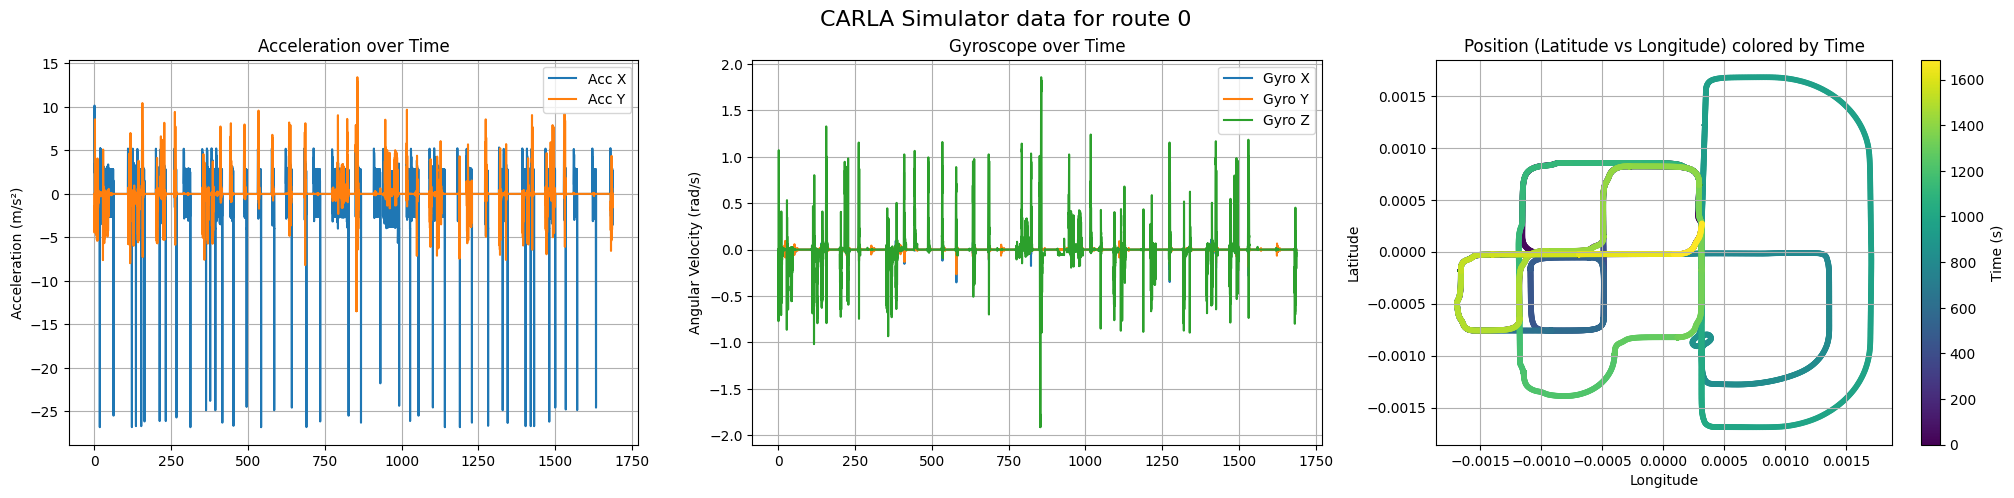

In [8]:
town = 'Town05'  # Use Town01_Opt for a lighter version of Town01
os.makedirs(f'plot_experiment2_carla_{town}', exist_ok=True)
for f in os.listdir(f'data_experiment2_carla_{town}'):
    idx = re.sub(r'\D', '', f)  # Extract the numeric part from the filename
    plot_df(pd.read_csv(f'data_experiment2_carla_{town}/{f}'), idx, save_path=f'plot_experiment2_carla_{town}/{f[:-4]}.png')